In [1]:
%pylab inline
import seaborn as sbn
import networkx as nx
import pickle
import scipy as sp
import scipy.stats
from scipy.optimize import curve_fit
import glob
import os
from Bio.PDB import *
from MDAnalysis import *
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
sbn.set(font_scale=1.5)  # crazy big
sbn.set_style("ticks")
sbn.despine()

<Figure size 432x288 with 0 Axes>

In [3]:
lengths = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 19, 21, 23, 25, 28, 30, 33, 36, 40, 44, 48, 52, 58, 63, 69,
           76, 83, 91, 100, 110, 120, 132, 145, 158, 174, 191, 209, 229, 251, 275, 302]
# Some sensible index?
heixdip = 2

In [4]:
def func(x, a, b):
    return a * x ** (-b)


def func2(x, a):
    return a / x


def theofunc(x, C, N, ex):
    return (C) * np.power(N / (2 * (-x ** 2 + N * x - N)), ex)


def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [5]:
## Simulations of a given length 
def get_sim_data_for_given_length(length):
    sim_data_files = glob.glob('../data/K50/Nora50_matrix_%s_*' %length)
    link_length_list = []
    for f in sim_data_files:
        M = np.loadtxt(f)
        M[M > 1] = 0
        G = nx.from_numpy_matrix(M)
        sim_Li = list(G.edges())
        for link in sim_Li:
            link_length_list.append(abs(link[0] - link[1]))
        sim_data_hist, sim_data_edges = np.histogram(link_length_list, bins=range(3, 1000), normed=True)
        # normalise over number of simulations:
    sim_data_hist = sim_data_hist/len(sim_data_files)
    return sim_data_hist, sim_data_edges

In [6]:
def get_pdb_data_for_given_length_range(pdb_files, lower_bound, upper_bound, verbose=False):   
    t = 8.0
    linklengths = []
    pdb_count = 0
    sim_data_hist = None
    sim_data_edges = None
    for pdb in pdb_files:
        u = Universe(pdb)
        calphas = u.select_atoms("name CA and segid " + u.residues.segments.segids[0])
        if verbose:
            print(len(calphas))
        if lower_bound <= len(calphas) <= upper_bound:
            r = calphas.positions
            maxdist = 0
            G = nx.empty_graph(len(r))
            avd = 0
            for i in range(len(r)):
                for j in range(i):
                    dist = np.linalg.norm(r[i] - r[j])
                    maxdist = max(dist, maxdist)
                    avd += dist ** 2
                    if dist < t:
                        G.add_edge(i, j)
                        linklengths.append(dist)
            avd = np.sqrt(avd) / (len(r))
            # take largest component
            if len(G.edges()) > 0:
                G = list(connected_component_subgraphs(G))[0]
                lena = len(G.nodes())
                Li = list(set(G.edges()) - set(nx.cycle_graph(lena).edges()))
                link_length_list = []
                for link in Li:
                    link_length_list.append(abs(link[0] - link[1]))
                sim_data_hist, sim_data_edges = np.histogram(link_length_list, bins=range(3, 1000), normed=True)
            pdb_count +=1
    if sim_data_hist is not None:
        sim_data_hist = sim_data_hist/pdb_count
    return sim_data_hist, sim_data_edges

    

## 200

In [7]:
pdb_files = glob.glob("../data/both/*.pdb")
#pdb_files = glob.glob("../data/idp/*.pdb")
pdb_data, edges_pdb = get_pdb_data_for_given_length_range(pdb_files,180,220)
bin_centers_pdb = edges_pdb[:-1] + np.diff(edges_pdb)/2

In [8]:
# Read simulation data of length 209
sim_data, edges = get_sim_data_for_given_length('209')
bin_centers = edges[:-1] + np.diff(edges)/2

In [9]:
# Normalising simulation data
bin_width= edges[1]-edges[0]
summing=0
for i in range(len(sim_data)):
    summing = summing+sim_data[i]*bin_width
print(summing)
sim_data = sim_data/summing

0.03333333333333333


In [10]:
# Normalising pdb data
bin_width= edges[1]-edges[0]
summing=0
for i in range(len(pdb_data)):
    summing = summing+pdb_data[i]*bin_width
print(summing)
pdb_data = pdb_data/summing

0.037037037037037035


sim fit [0.10362094 0.82982762]
pdb fit [0.02478929 0.45082884]


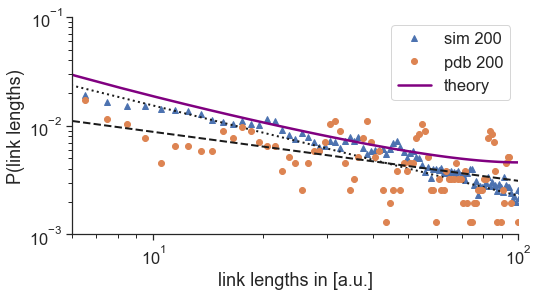

In [25]:
## Plotting
plt.figure(figsize=(8,4))

# plotting the simulation data
plt.plot(bin_centers,sim_data, linewidth=0, marker='^', label='sim 200')
fit, ficov = curve_fit(func,bin_centers[heixdip:-1], sim_data[heixdip:-1])
print('sim fit', fit)
plt.plot(bin_centers, func(bin_centers, fit[0], fit[1]), ':',color ='k', lw=2)

# plotting pdb data
plt.plot(bin_centers_pdb,pdb_data, linewidth=0, marker='o', label='pdb 200')
fit, ficov = curve_fit(func,bin_centers_pdb[4:100], pdb_data[4:100])
print('pdb fit', fit)
plt.plot(bin_centers_pdb, func(bin_centers_pdb, fit[0], fit[1]), '--',color ='k', lw=2)

# theory
simlen = np.linspace(0, 100, num=50)
plt.plot(np.array(simlen), theofunc(np.array(simlen), 0.18, 200.0, 0.8), label='theory', lw =2.5, color='purple')


plt.yscale('log')
plt.xscale('log')
plt.xlim([6, 100])
plt.ylim([0.001, 0.1])
plt.legend()
sbn.despine()
plt.ylabel("P(link lengths)")
plt.xlabel("link lengths in [a.u.]")
plt.savefig('both_200.pdf')


## 400

In [19]:
pdb_files = glob.glob("../data/both/*.pdb")
#pdb_files = glob.glob("../data/idp/*.pdb")
pdb_data, edges_pdb = get_pdb_data_for_given_length_range(pdb_files,380,420)
bin_centers_pdb = edges_pdb[:-1] + np.diff(edges_pdb)/2

In [20]:
# Read simulation data of length 398
sim_data, edges = get_sim_data_for_given_length('398')
bin_centers = edges[:-1] + np.diff(edges)/2

In [21]:
# Normalising simulation data
bin_width= edges[1]-edges[0]
summing=0
for i in range(len(sim_data)):
    summing = summing+sim_data[i]*bin_width
print(summing)
sim_data = sim_data/summing

0.033333333333333326


In [22]:
# Normalising pdb data
bin_width= edges[1]-edges[0]
summing=0
for i in range(len(pdb_data)):
    summing = summing+pdb_data[i]*bin_width
print(summing)
pdb_data = pdb_data/summing

0.09999999999999978


sim fit [0.10362094 0.82982762]
pdb fit [0.03324892 0.55224476]


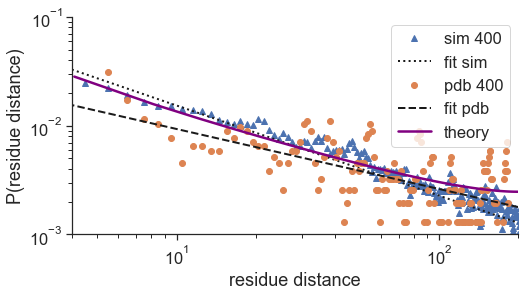

In [26]:
## Plotting
plt.figure(figsize=(8,4))

# plotting the simulation data
plt.plot(bin_centers,sim_data, linewidth=0, marker='^', label='sim 400')
fit, ficov = curve_fit(func,bin_centers[heixdip:-1], sim_data[heixdip:-1])
print('sim fit', fit)
plt.plot(bin_centers, func(bin_centers, fit[0], fit[1]), ':',color ='k', lw=2, label='fit sim')

# plotting pdb data
plt.plot(bin_centers_pdb,pdb_data, linewidth=0, marker='o', label='pdb 400')
fit, ficov = curve_fit(func,bin_centers_pdb[4:200], pdb_data[4:200])
print('pdb fit', fit)
plt.plot(bin_centers_pdb, func(bin_centers_pdb, fit[0], fit[1]), '--',color ='k', lw=2, label='fit pdb')

# theory
simlen = np.linspace(0, 200, num=50)
plt.plot(np.array(simlen), theofunc(np.array(simlen), 0.1, 400.0, 0.7), label='theory', lw =2.5, color='purple')


plt.yscale('log')
plt.xscale('log')
plt.xlim([4, 200])
plt.ylim([0.001, 0.1])
plt.legend()
sbn.despine()
plt.ylabel("P(residue distance)")
plt.xlabel("residue distance")

plt.savefig('both_400.pdf')


## GPCRs

### 2.1 Downloading GPCRS:

In [30]:
import urllib
import pandas as pd
query = pd.read_csv('../data/trans_membrane_helical/200_300.csv')

In [20]:
for pdb in query.columns:
    #print (pdb)
    download = 'https://files.rcsb.org/download/%s.pdb' %pdb
    #print(download)
    urllib.request.urlretrieve(download, '../data/trans_membrane_helical/200_300/'+pdb+'.pdb')

In [27]:
pdb_files = glob.glob("../data/trans_membrane_helical/200_300/*.pdb")
pdb_data, edges_pdb = get_pdb_data_for_given_length_range(pdb_files, 190,220, verbose=True)

156
230
229
197
182
106
203
176
52
191
244
446
267
235
105
239
264
189
202
234
231
203
189
174
223
256
106
189
86
261
195
204
268
227
181
104
198
257
100
264
272
231
269
222
215
232
273
224
188
225
271
264
267
259
23
230
222
234
221
224
250
216
195
180
229
207
207
207
212
308
231
225
274
228
249
139
181
225
264
240
192
178
280
106
106
251
275
231
293
99
139
428
233
234
235
296
239
25
271
175


sim fit [0.00653741 1.05283777]


Text(0.5, 0, 'link lengths in [a.u.]')

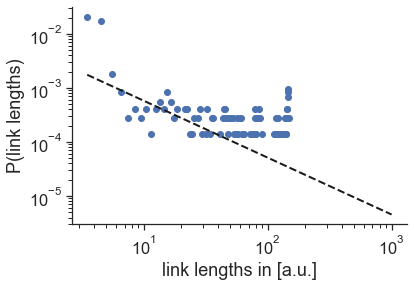

In [31]:
# plotting pdb data
bin_centers_pdb = edges_pdb[:-1] + np.diff(edges_pdb)/2
plt.plot(bin_centers_pdb,pdb_data, linewidth=0, marker='o', label='sim 200')
fit, ficov = curve_fit(func,bin_centers_pdb[heixdip:-1], pdb_data[heixdip:-1])
print('sim fit', fit)
plt.plot(bin_centers_pdb, func(bin_centers_pdb, fit[0], fit[1]), '--',color ='k', lw=2)

plt.yscale('log')
plt.xscale('log')
#plt.xlim([5, 100])
#plt.ylim([0.01, 200])
#plt.legend()
sbn.despine()
plt.ylabel("P(link lengths)")
plt.xlabel("link lengths in [a.u.]")

## PDB Statistics

In [32]:
data = pd.read_csv('../data/pdb_statistics/residue_count.csv', names=['Residue Count', 'Number of Proteins'])

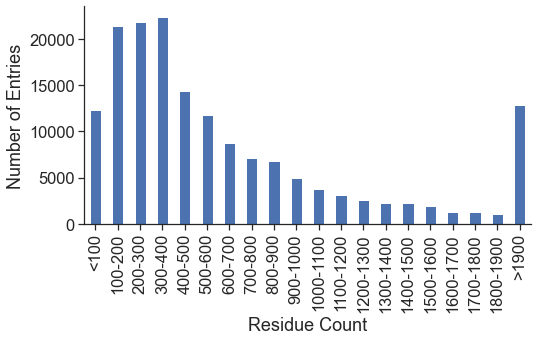

In [33]:
ax = data.plot.bar(x='Residue Count', y='Number of Proteins', rot=90, figsize=(8,4), legend=False)
ax.set_ylabel("Number of Entries")
sbn.despine()
plt.savefig('../paper/figures/pdb_statistics.pdf')